### Twitter Sentiment Analysis - Gov CDMX

In [35]:
from datalab.context import Context
import google.datalab.storage as storage
import google.datalab.bigquery as bq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import time
from tensorflow.python.lib.io import file_io

In [36]:
!export GOOGLE_APPLICATION_CREDENTIALS="/Users/admin/Downloads/gov-cdmx-twitter-sentiment-3479e766b2c0.json"

In [37]:
!pip install --upgrade google-api-python-client

Requirement already up-to-date: google-api-python-client in /Users/admin/development/gov-cdmx-twitter-sentiment/streaming/env/lib/python3.7/site-packages (1.9.3)


In [38]:
%!bq tables describe --name gov-cdmx-twitter-sentiment:gov_cdmx_twitter_sentiment.tweets

UsageError: Line magic function `%!bq` not found.


Now that the data is in bigquery we can save a section to cloud storage or grab it direct from bigquery.

In [39]:
with file_io.FileIO('gs://gov-cdmx-twitter-sentiment/nlpstorage/bq-results-20200615-230130-tea37r5zc4u0.csv', 'r') as f:
    df = pd.read_csv(f)

In [40]:
df = df.head()

In [41]:
print(df['user_text'][0])
print(len(df['user_text']))

"RT @fantasmasuarez: Las ratas anarquistas"
5


In [42]:
rts=df[df['user_text'].str.match('"RT')]
print("Retweets ", len(rts['user_text']))
cdmx=df[df['user_text'].str.contains('#CDMX')]
print("CDMX", len(cdmx['user_text']))

Retweets  2
CDMX 1


In [43]:
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
from google.oauth2 import service_account
from google.protobuf.json_format import MessageToDict, MessageToJson

score=[]
magnitude=[]
creds = service_account.Credentials.from_service_account_file('/Users/admin/Downloads/gov-cdmx-twitter-sentiment-53dba8db6dbd.json')
client = language.LanguageServiceClient(credentials=creds)

for tweet in cdmx['user_text']:
    document = types.Document(
    content=tweet,
    type=enums.Document.Type.PLAIN_TEXT
    )
    analyze_sentiment_response = client.analyze_sentiment(document=document)
    message = MessageToDict(analyze_sentiment_response, including_default_value_fields=True)
    score.append(message['documentSentiment']['score'])
    magnitude.append(message['documentSentiment']['magnitude'])

print(len(score))
# print('POLARITY=%s MAGNITUDE=%s for %s' % (score, magnitude, tweet))

1


In [ ]:
cdmx['score']=score
cdmx['magnitude']=magnitude
cdmx.head()

In [14]:
cdmx['datef']=pd.to_datetime(cdmx['tweet_timestamp'], unit='s', yearfirst='TRUE')
cdmx['datef'].head()

/Users/admin/development/gov-cdmx-twitter-sentiment/streaming/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


4    2020-06-10 15:31:11
11   2020-06-10 15:31:11
12   2020-06-10 15:31:11
19   2020-06-10 15:31:11
27   2020-06-10 15:31:11
Name: datef, dtype: datetime64[ns]

In [15]:
#averages
score_avg=np.mean(cdmx['score'])
magnitude_evg=np.mean(cdmx['magnitude'])
print('score', score_avg, 'magnitude', magnitude_evg)

score 0.1990825688073395 magnitude 0.4137614678899083


Text(0, 0.5, 'Magnitude')

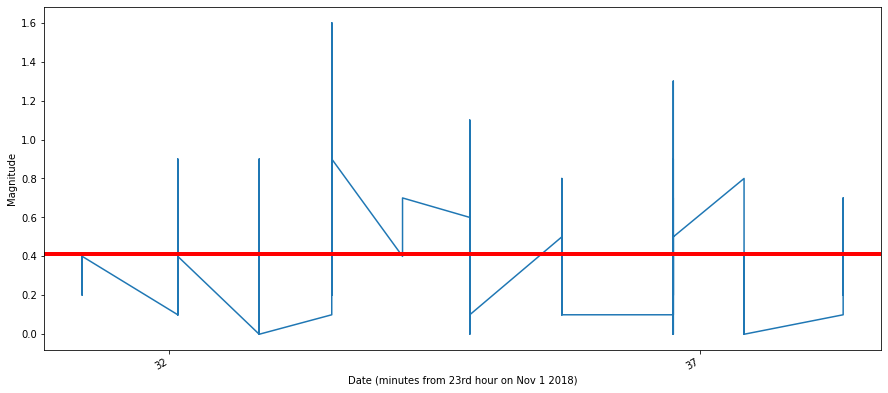

In [16]:
data = pd.concat([cdmx['datef'], cdmx['magnitude']], axis=1)
data.set_index('datef',inplace=True)
fig, ax = plt.subplots(figsize=(15,7))
data.plot(ax=ax, legend=False)
ax.axhline(y=magnitude_evg, linewidth=4, color='r')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.set_xlabel('Date July 10th ~3:30 P.M')
ax.set_ylabel('Magnitude')

Text(0, 0.5, 'Score')

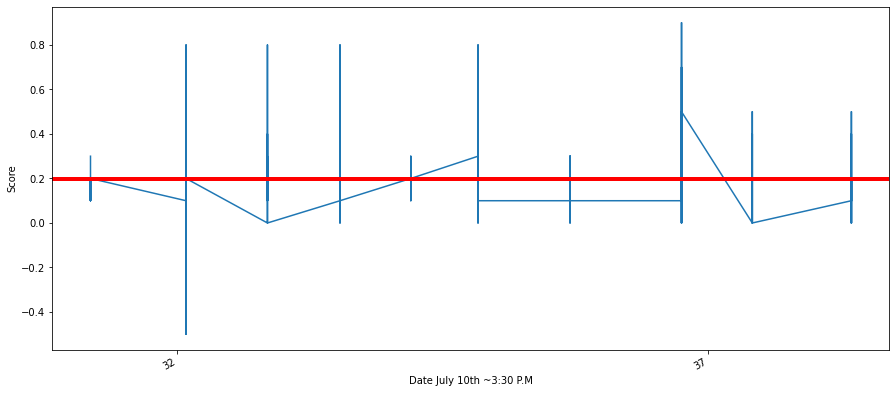

In [20]:
data2 = pd.concat([cdmx['datef'], cdmx['score']], axis=1)
data2.set_index('datef',inplace=True)
fig, ax2 = plt.subplots(figsize=(15,7))
data2.plot(ax=ax2, legend=False)
ax2.axhline(y=score_avg, linewidth=4, color='r')
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax2.set_xlabel('Date July 10th ~3:30 P.M')
ax2.set_ylabel('Score')

High magnitude tweets are more impactful than low magnitude tweets, a weak statement doesn't say much.
We will concentrate only on statements with a magnitude of 0.5 or higher.

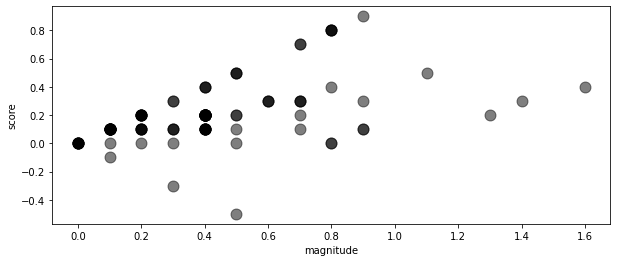

In [21]:
fig, ax = plt.subplots()
ax.figure.set_size_inches(10,4)
ax.grid(False)
#ax.scatter(google.magnitude[google['magnitude'] >=0.5], google.polarity[google['magnitude'] >=0.5], s=120, c='black', alpha=0.5)
ax.scatter(cdmx.magnitude, cdmx.score, s=120, c='black', alpha=0.5)
ax.set(xlabel='magnitude', ylabel='score')
plt.show()

We can also see that things around zero polarity (neither very positive nor negative) are not interesting to flag 

In [22]:
love=cdmx[(cdmx['magnitude'] >=0.5) & (cdmx['score'] >=0.5)]
hate=cdmx[(cdmx['magnitude'] >=0.5) & (cdmx['score'] <= -0.5)]

In [23]:
print(len(cdmx['magnitude']), len(love['magnitude']), len(hate['magnitude']))
print("weak", len(cdmx['magnitude']) - (len(love['magnitude'])+len(hate['magnitude'])))

109 11 1
weak 97


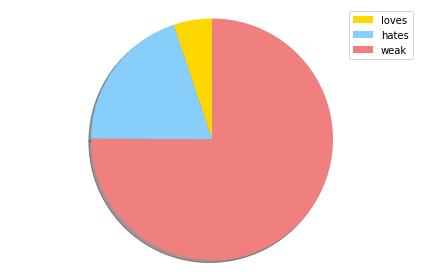

In [24]:
labels = ['loves', 'hates', 'weak']
sizes = [30, 115, 437]
colors = ['gold', 'lightskyblue', 'lightcoral']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

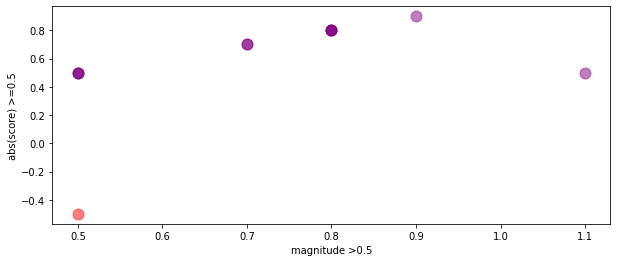

In [29]:
fig, ax= plt.subplots()
ax.scatter(love.magnitude, love.score, s=120, c='purple', alpha=0.5)
ax.scatter(hate.magnitude, hate.score, s=120, c='red', alpha=0.5)
ax.figure.set_size_inches(10,4)
ax.grid(False) 
ax.set(xlabel='magnitude >0.5', ylabel='abs(score) >=0.5')
plt.show()

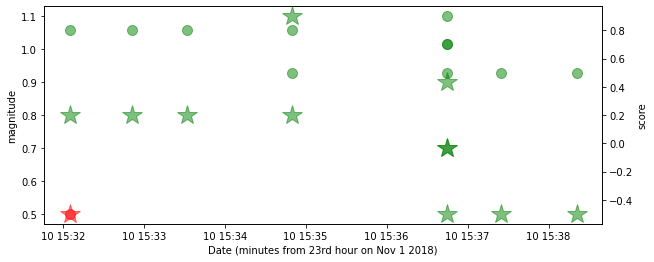

In [31]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Date July 10th ~3:30 P.M')
ax1.set_ylabel('magnitude')
ax1.grid(False)
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax1.figure.set_size_inches(10,4)
ax1.plot(love['datef'], love['magnitude'], 'g*', markersize=20, alpha=0.5)
ax1.plot(hate['datef'], hate['magnitude'], 'r*', markersize=20, alpha=0.5)
ax2=ax1.twinx()
ax2.grid(False)
ax2.plot(love.datef, love.score, 'g.', markersize=20, alpha=0.5)
ax2.plot(hate.datef, hate.score, 'r.', markersize=20, alpha=0.5)
ax2.set_ylabel('score')
#ax2.axhline(y=polavg, linewidth=4, color='r')
plt.show()

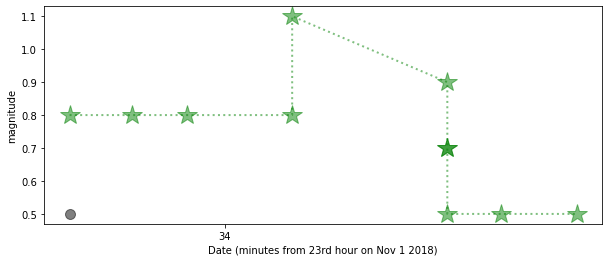

In [32]:
fig, ax = plt.subplots()
ax.set_xlabel('Date (minutes from 23rd hour on Nov 1 2018)')
ax.grid(False)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.figure.set_size_inches(10,4)
ax.plot(love['datef'], love['magnitude'], 'g', linestyle=':', marker='*', linewidth=2, markersize=20, alpha=0.5)
ax.plot(hate['datef'], hate['magnitude'], 'k', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
ax.set_ylabel('magnitude')
plt.show()

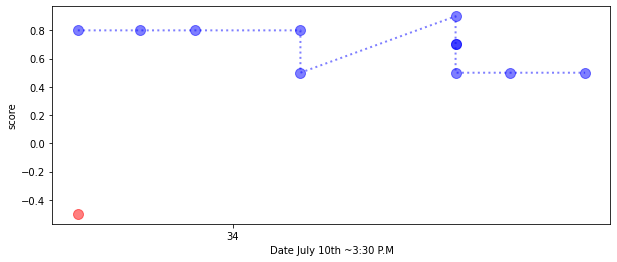

In [34]:
fig, ax = plt.subplots()
ax.set_xlabel('Date July 10th ~3:30 P.M')
ax.set_ylabel('score')
ax.grid(False)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M'))
ax.figure.set_size_inches(10,4)
ax.plot(love['datef'], love['score'], 'b', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
ax.plot(hate['datef'], hate['score'], 'r', linestyle=':', marker='.', linewidth=2, markersize=20, alpha=0.5)
plt.show()